## **IMPORTS**

In [1]:
import os
print(f"# --- VERIFICATION DU REPERTOIRE COURANT : {os.getcwd()}")
import sys
# --- ACCES A SRC
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# A--- JOUT DE src AU sys.path
if src_path not in sys.path:
    sys.path.append(src_path)
print(f"# --- CHEMIN AJOUTE AU sys.path : {src_path}")
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from scipy.stats import entropy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import ast
from tags_suggester.preprocessing import text_cleaning
from tags_suggester.preprocessing.text_cleaning import load_tech_terms
from tags_suggester.eda.eda_analysis import plot_distribution

# --- VERIFICATION DU REPERTOIRE COURANT : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks
# --- CHEMIN AJOUTE AU sys.path : d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


## **1. RECUPERATION DES DONNEES**

### **1.1. EXTRACTION DES DONNEES VIA STACK EXCHANGE DATA EXPLORER**

### **1.2. CHARGEMENT DES DONNEES DANS UN DATAFRAME**

In [2]:
# ---------------------------
# --- CHARGER LE FICHIER CSV
# ---------------------------
full_df = pd.read_csv("../data/raw/stackoverflow_questions_sede.csv")
# -----------------------------------------------
# --- VERIFIER LE NOMBRE DE LIGNES ET UN APERCU
# -----------------------------------------------
print(f"Nombre de questions : {len(full_df)}")

Nombre de questions : 50000


## **2. NETTOYAGE DES DONNEES**

**Objectif : transformer du texte brut en texte propre et exploitable**

### 2.1. CREATION DE FILTRES TEXTUELS

In [3]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES DE NETTOYAGES
# -------------------------------------------
import importlib
import tags_suggester.preprocessing.text_cleaning as tc
importlib.reload(tc)

# -----------------------------------------------------
# --- ETAPE 0. Préparation des sets de mots à exclure
# -----------------------------------------------------
# --- OXFORD TERMS
oxford_terms = tc.extract_oxford_terms(
    path="../src/tags_suggester/config/oxford3000.txt",
    export_cleaned_path="../src/tags_suggester/config/oxford_cleaned.txt",
    verbose=False
)
print(f"Nombre de mots dans oxford_cleaned.txt : {len(oxford_terms)}")
# --- CUSTOM TERMS
stop_terms_custom = tc.load_stop_terms("../src/tags_suggester/config/stop_terms.txt")
# stop_terms_custom = tc.custom_stop_terms
print(f"Nombre de mots dans stop_terms.txt : {len(stop_terms_custom)}")
# --- VAGUE TERMS
vague_path = tc.generate_vague_terms(path="../src/tags_suggester/config/vague_terms.txt", verbose=True)
vague_terms = tc.load_stop_terms(vague_path)
print(f"Nombre de mots dans vague_terms.txt : {len(vague_terms)}")
# --- COMBINAISON DE CE QU'ON VEUT EXCLURE
stopwords_set = tc.combined_stopwords.union(stop_terms_custom).union(oxford_terms).union(vague_terms)
print(f"Nombre de mots exclus : {len(stopwords_set)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nombre de mots dans oxford_cleaned.txt : 1183
Nombre de mots dans stop_terms.txt : 260
✅ 51 termes vagues enregistrés dans : ../src/tags_suggester/config/vague_terms.txt
Nombre de mots dans vague_terms.txt : 260
Nombre de mots exclus : 1679


### 2.2. NETTOYAGE


In [4]:
import os
import gc
import importlib
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import tags_suggester.preprocessing.text_cleaning as tc
importlib.reload(tc)

# ------------------------------------------------------------------------------
# --- ON EXTRAIT 10K SUR LES 50K QUESTIONS POUR GERER DES DUREES DE TRAITEMENT GERABLES
# ------------------------------------------------------------------------------
brut_df = full_df.sample(10000, random_state=42).copy()
# -----------------------------------------
# --- DECOUPAGE DE L'ECHANTILLON EN CHUNKS
# -----------------------------------------
# --- PARAMÈTRES DE STOCKAGE DES CHUNKS AU FORMAT .parquet
chunk_size = 5000
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"../data/processed/brut_chunks_{timestamp}"
# --- CREATION DU DOSSIER SI ABSENT
os.makedirs(output_dir, exist_ok=True)  
# --- CALCUL DU NOMBRE DE CHUNKS
n_chunks = len(brut_df) // chunk_size + int(len(brut_df) % chunk_size > 0)
# ---------------------------------------
# --- TRAITEMENT ITERATIF SUR LES CHUNKS
# ---------------------------------------
for chunk_index in tqdm(range(n_chunks), desc="Nettoyage & sauvegarde des chunks"):
    start = chunk_index * chunk_size
    end = start + chunk_size
    batch = brut_df.iloc[start:end].copy()
    texts = [
    f"{title} {body}" 
    for title, body in zip(batch["Title"].fillna(""), batch["Body"].fillna(""))
    ]
    docs = tc.nlp.pipe(texts, batch_size=250, disable=["parser", "ner"])
    batch["clean_title_body"] = [
        tc.clean_doc_spacy_custom(doc, stopwords_set=stopwords_set) for doc in docs
    ]
    # --- SAUVEGARDE DU CHUNK EN .parquet
    chunk_path = os.path.join(output_dir, f"chunk_{chunk_index+1:02}.parquet")
    batch.to_parquet(chunk_path, index=False)
    print(f"# --- CHUNK {chunk_index+1}/{n_chunks} sauvegardé → {chunk_path}")
    # --- NETTOYAGE DE LA MÉMOIRE POUR NE PAS RALENTIR LE PC
    gc.collect()
# -------------------------------------------------------------------------------
# --- REASSEMBLAGE DES .parquet POUR FORMER LE CORPUS NETTOYE PRET POUR ANALYSE
# -------------------------------------------------------------------------------
import glob
files = sorted(glob.glob(os.path.join(output_dir, "chunk_*.parquet")))
print(f"""# --- LES CHUNKS SONT ASSEMBLES A PARTIR DES FICHIERS DU REPERTOIRE HORODATE :
             {output_dir}""")
brut_df_clean = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
# -----------------------------------------------------------------
# --- AFFICHAGE DES 5 PREMIERES LIGNES DU CORPUS POUR VERIFICATION
# -----------------------------------------------------------------
display(brut_df_clean["clean_title_body"].head)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Nettoyage & sauvegarde des chunks:  50%|█████     | 1/2 [02:55<02:55, 175.98s/it]

# --- CHUNK 1/2 sauvegardé → ../data/processed/brut_chunks_20250812_1445\chunk_01.parquet


Nettoyage & sauvegarde des chunks: 100%|██████████| 2/2 [05:24<00:00, 162.38s/it]

# --- CHUNK 2/2 sauvegardé → ../data/processed/brut_chunks_20250812_1445\chunk_02.parquet
# --- LES CHUNKS SONT ASSEMBLES A PARTIR DES FICHIERS DU REPERTOIRE HORODATE :
             ../data/processed/brut_chunks_20250812_1445


<bound method NDFrame.head of 0       haskell maps balanced binary tree traditional ...
1       measure average thickness trace image number b...
2       dynamic linq join extension dynamic wiki exten...
3       pre java prettyprint testa tostring args testa...
4       cluster datum pd pd j b j b plot dataframe ind...
                              ...                        
9995    target late android theme late android sdk man...
9996    enable real positioning samsung android browse...
9997    mongodb possible mongo db collection document ...
9998    rail pdf attach render pdf actionmailer attach...
9999    reliable key database linux fast reliable key ...
Name: clean_title_body, Length: 10000, dtype: object>

## **3. EXPLORATION**

#### **3.1. FREQUENCE DES MOTS**

,word,frequency
0,android,3312
1,datum,2689
2,user,2593
3,application,2501
4,app,2480
...,...,...
95,current,601
96,window,600
97,site,600
98,cache,595


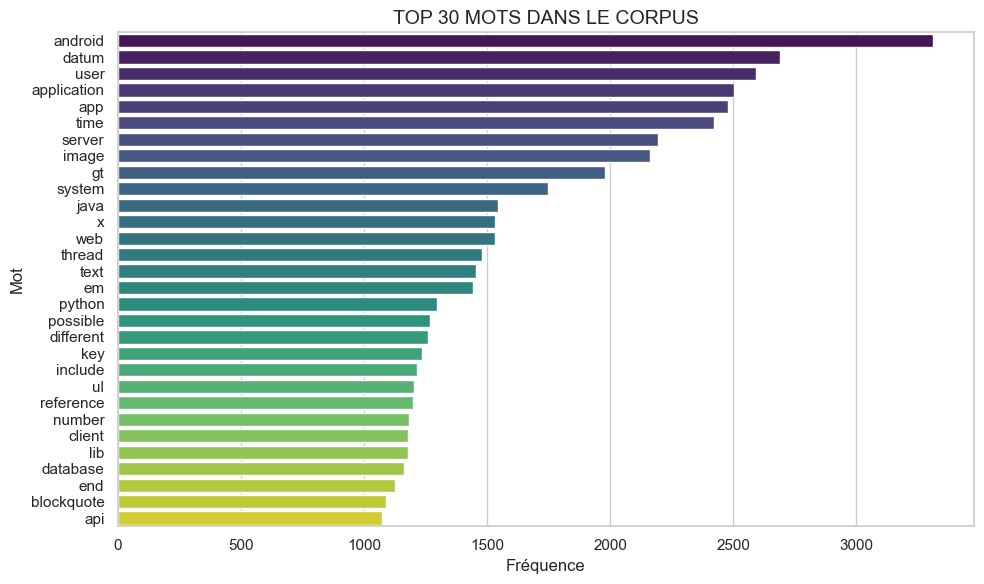

In [5]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# -----------------------------------------------------
# --- COPIE POUR NE PAS MODIFIER LE DATAFRAME ORIGINAL
# -----------------------------------------------------
full_explo = brut_df_clean.copy()

# --------------------------
# --- CALCUL DES FREQUENCES
# --------------------------
# --- TOP 100 LEMMES SANS LES STOPWORDS PERSONNALISES
freq_clean_title_body = eda.compute_word_frequencies(
    df=full_explo,
    column="clean_title_body",
    top_n=100
)
display(freq_clean_title_body)
# ---------------------------------
# --- VISUALISATION DES TOP TOKENS
# ---------------------------------
n_top_freq = 30
eda.plot_word_frequencies(
    df_freq=freq_clean_title_body,
    max_words_display=30,
    palette="viridis",
    title=f"TOP {n_top_freq} MOTS DANS LE CORPUS"
)

#### **3.2. NUAGE DE MOTS**

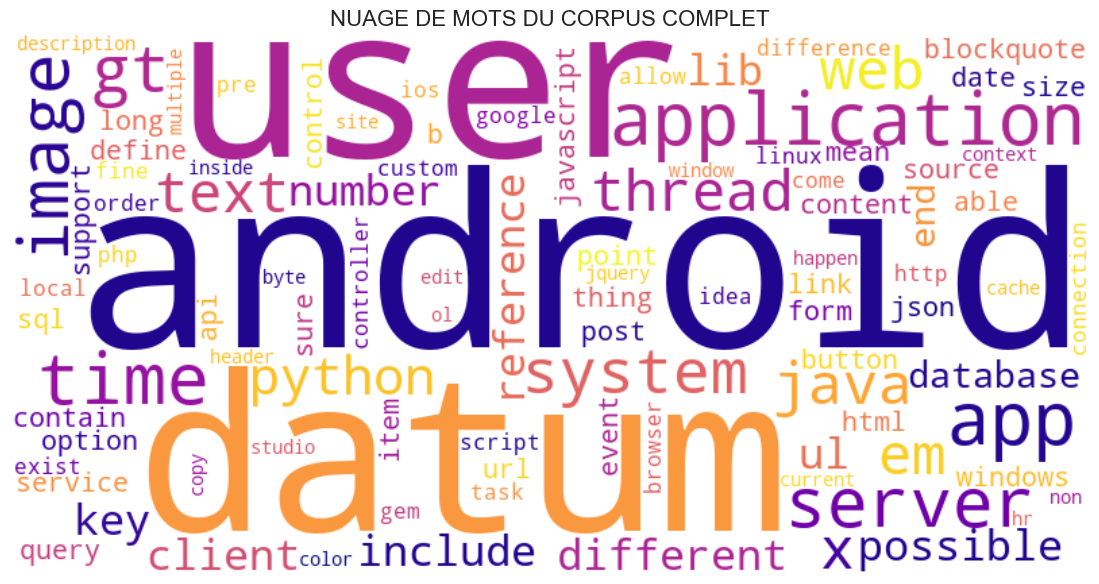

In [6]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)
cloud_title = "NUAGE DE MOTS DU CORPUS COMPLET"
eda.generate_wordcloud(
    df_freq=freq_clean_title_body,
    max_words=100,
    colormap="plasma",
    title=f"{cloud_title}"
)

#### **3.3. ANALYSE DE LA LONGUEUR DES DOCUMENTS ET DE LA FORME DE SA DISTRIBUTION**

Index(['PostId', 'Title', 'Body', 'Score', 'ViewCount', 'AnswerCount',
       'CreationDate', 'TagCount', 'Tags', 'clean_title_body'],
      dtype='object')

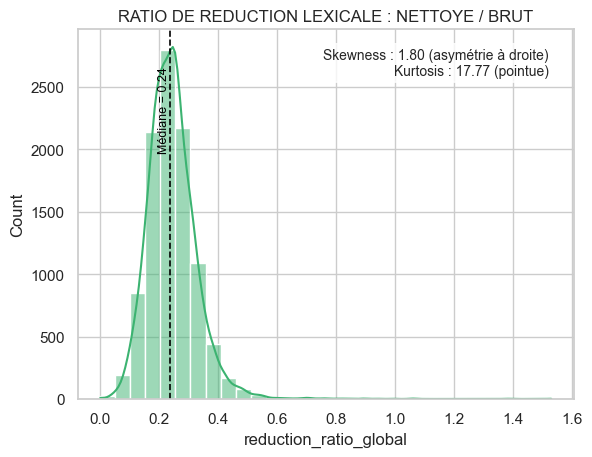

In [7]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

display(full_explo.columns)
# ---------------------------------------------------------------
# --- RECONSTRUCTION DU CORPUS BRUT PAR FUSION DE TITLE ET BODY
# ---------------------------------------------------------------
full_explo["title_body_raw"] = full_explo["Title"].fillna("") + " " + full_explo["Body"].fillna("")
# ---------------------------------
# --- CALCUL DES LONGUEURS EN MOTS
# ---------------------------------
full_explo["length_words_raw"] = full_explo["title_body_raw"].str.split().apply(len)
full_explo["length_words_clean"] = full_explo["clean_title_body"].str.split().apply(len)
# -------------------------------------------------
# --- RATIO DE REDUCTION LEXICALE : NETTOYE / BRUT
# -------------------------------------------------
full_explo["reduction_ratio_global"] = full_explo["length_words_clean"] / full_explo["length_words_raw"]
# ----------------------------------------------------------------------
# --- VISUALISATION DE CE RATIO DE REDUCTION LEXICALE : NETTOYE / BRUT
# ----------------------------------------------------------------------
title_ratio = "RATIO DE REDUCTION LEXICALE : NETTOYE / BRUT"
eda.plot_distribution(
    ax=plt.gca(),
    data=full_explo["reduction_ratio_global"],
    title=f"{title_ratio}",
    color="mediumseagreen"
)

#### **3.4. DETECTION DES OUTLIERS ET DOUBLONS**

##### ***3.4.1. DÉTECTION DES DOUBLONS EXACTS***

In [8]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# --------------------------------------------------------
# --- DETECTION DES DOUBLONS EXACTS SUR LE CORPUS NETTOYE
# --------------------------------------------------------
# --- CREATION DU MASQUE
exact_dup_mask = full_explo.duplicated(subset=["clean_title_body"], keep=False)
exact_duplicates_df = full_explo[exact_dup_mask]

# --- CALCUL DU NOMBRE DE DUPLICATS
nb_duplicates = exact_duplicates_df.shape[0]
nb_unique = exact_duplicates_df.duplicated(subset=["clean_title_body"]).sum()
total = full_explo.shape[0]
print(f"Nombre total de questions : {total}")
print(f"Nombre de doublons exacts (clean_title_body) : {nb_duplicates}")
print(f"Nombre de doublons à supprimer (copies identiques) : {nb_unique}")
print(f"Proportion de doublons dans le corpus : {nb_duplicates / total:.2%}")

# --- AFFICHAGE DE QUELQUES DOUBLONS
exact_duplicates_df.sort_values("clean_title_body").head(6)[["PostId", "clean_title_body"]]
# ---------------------------
# --- GESTION DES DOUBLONS
# ---------------------------
# --- SUPPRESSION DES DOUBLONS EXACTS (MAIS ON GARDE LA PREMIERE OCCURRENCE)
full_explo = full_explo.drop_duplicates(subset=["clean_title_body"], keep="first").reset_index(drop=True)
display(exact_duplicates_df)

Nombre total de questions : 10000
Nombre de doublons exacts (clean_title_body) : 5
Nombre de doublons à supprimer (copies identiques) : 4
Proportion de doublons dans le corpus : 0.05%


,PostId,Title,Body,Score,ViewCount,AnswerCount,CreationDate,TagCount,Tags,clean_title_body,title_body_raw,length_words_raw,length_words_clean,reduction_ratio_global
4397,8757389,Reading a file line by line in Go,<p>I'm unable to find <code>file.ReadLine</cod...,583,653852,13,2012-01-06 11:50:24,5,string;parsing;file;line;go,,Reading a file line by line in Go <p>I'm unabl...,25,0,0.0
5099,3533774,VB.NET: Get class name of a instance,<p>Is there a way to get the instance's class ...,25,41763,4,2010-08-20 18:29:07,5,.net;vb.net;oop;class;instance,,VB.NET: Get class name of a instance <p>Is the...,19,0,0.0
5923,11202673,Converting string to float in C#,"<p>I am converting a string like ""41.000273576...",141,763001,9,2012-06-26 07:35:01,5,.net;c#;string;floating-point;type-conversion,,Converting string to float in C# <p>I am conve...,40,0,0.0
6681,4691699,How to convert .crt to .pem,<p>How can I convert .crt to .pem?</p>\n,367,1124293,2,2011-01-14 13:49:40,5,asn.1;crt;pem;x509;der,,How to convert .crt to .pem <p>How can I conve...,13,0,0.0
9867,2344411,How to convert string to integer in C#,<p>How do I convert a string to an integer in ...,101,243765,12,2010-02-26 19:57:19,5,.net;c#;string;int;type-conversion,,How to convert string to integer in C# <p>How ...,19,0,0.0


##### ***3.4.2. GESTION DES OUTLIERS***

In [9]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------
# --- DETECTION DES OUTLIERS (METHODE IQR)
# ---------------------------
full_explo, full_outliers = eda.mark_outliers(
    df=full_explo,
    columns=[
        "length_words_clean",
        "reduction_ratio_global"
    ],
    verbose=True,
    return_outliers=True
)
# ------------------------------
# --- SUPPRESSION DES OUTLIERS
# ------------------------------
full_explo_wo = eda.remove_outliers(full_explo)
print(f"# --- QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERSS OUTLIERS : {full_explo_wo.shape[0]}")
full_explo_wo.to_csv("../data/processed/full_explo_wo_wet.csv", index=False)

Outliers détectés par variable :
- length_words_clean : 762
- reduction_ratio_global : 215

Nombre total d’outliers (au moins une variable) : 905
Proportion dans l’échantillon : 9.05%
# --- QUESTIONS RESTANTES APRES SUPPRESSION DES OUTLIERSS OUTLIERS : 9091


#### **3.5. ANALYSE DES TAGS**

##### 3.5.1. STRUCTURATION DES TAGS

In [10]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ------------------------------
# --- APERCU DE LA COLONNE TAGS
# ------------------------------
print(full_explo_wo["Tags"].head(10))
print(full_explo_wo["Tags"].apply(type).value_counts())
# ---------------------------------------
# --- CONVERSION DES CHAINES EN LISTES
# ---------------------------------------
full_explo_wo["Tags"] = full_explo_wo["Tags"].apply(lambda x: x.split(";") if isinstance(x, str) else [])
# ---------------------------------
# --- VERIFICATION POST CONVERSION
# ---------------------------------
print(full_explo_wo["Tags"].apply(type).value_counts())

0    algorithm;haskell;hashtable;binary-search-tree...
1    language-agnostic;algorithm;image;image-proces...
2    linq;linq-to-objects;linq-to-entities;linq-to-...
3          java;oop;interface;instance;anonymous-class
4    python;matplotlib;seaborn;stacked-bar-chart;gr...
5                          maps;xcode;ios;swift;xcode6
6                 components;maven-2;mojo;plexus;maven
7    javascript;event-driven;frp;reactive-programmi...
8    c++;linker-errors;pure-virtual;vtable;undefine...
9    php;fastcgi;nginx;mod-fastcgi;http-status-code...
Name: Tags, dtype: object
Tags
<class 'str'>    9091
Name: count, dtype: int64
Tags
<class 'list'>    9091
Name: count, dtype: int64


##### 3.5.2. FREQUENCE DES TAGS

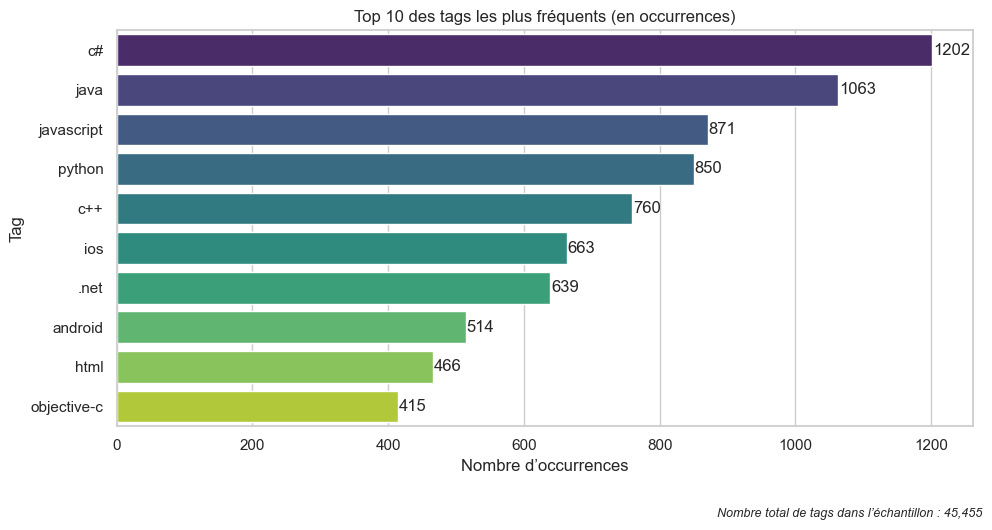

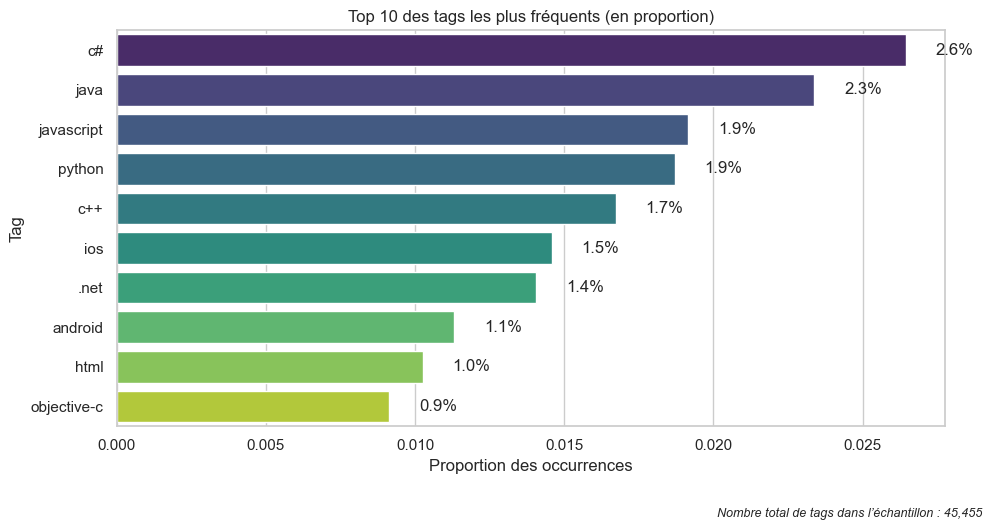

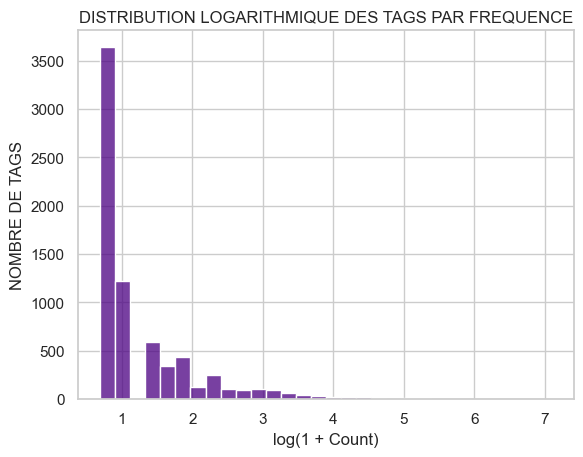

# --- NOMBRE DE TAGS AVEC UNE SEULE OCCURRENCE : 3638


In [11]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------
# --- ON APLATIT LA LISTE DES TAGS
# ---------------------------------
from collections import Counter
all_tags = [tag for tags in full_explo_wo["Tags"] for tag in tags]
# ------------------------------
# --- ON COMPTE LES OCCURRENCES
# ------------------------------
tag_counts = Counter(all_tags)
# ------------------------------------------------------
# --- CONVERSION EN PANDAS DATAFRAME POUR VISUALISATION
# ------------------------------------------------------
tag_freq_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"]).sort_values(by="Count", ascending=False)
tag_freq_df.reset_index(drop=True, inplace=True)
# -----------------------------------------
# ---AFFICHAGE DES TAGS LES PLUS FREQUENTS
# -----------------------------------------
tag_freq_df.head(10)
# ------------------
# --- VISUALISATIONS
# ------------------
# --- DISTRIBUTION DES TAGS PAR NOMBRE D'OCCURRENCES
eda.plot_tag_occurrences(tag_freq_df, top_n=10)
# --- DISTRIBUTION DES TAGS PAR PROPORTION D'OCCURRENCES
eda.plot_tag_distribution(tag_freq_df, top_n=10)
# --- DISTRIBUTION LOGARITHMIQUE DES TAGS PAR FREQUENCE
title_log = "DISTRIBUTION LOGARITHMIQUE DES TAGS PAR FREQUENCE"
tag_freq_df["log_count"] = np.log1p(tag_freq_df["Count"])
sns.histplot(tag_freq_df["log_count"], bins=30, color="indigo")
plt.title(f"{title_log}")
plt.xlabel("log(1 + Count)")
plt.ylabel("NOMBRE DE TAGS")
plt.show()
# -----------------------------
# --- DETECTION DES TAGS RARES
# -----------------------------
rare_tags = tag_freq_df[tag_freq_df["Count"] == 1]
print(f"# --- NOMBRE DE TAGS AVEC UNE SEULE OCCURRENCE : {len(rare_tags)}")

##### 3.5.3. ANALYSE DIVERSITE DES TAGS 

# --- NOMBRE DE TAGS DISTINCTS DANS LE CORPUS : 7259


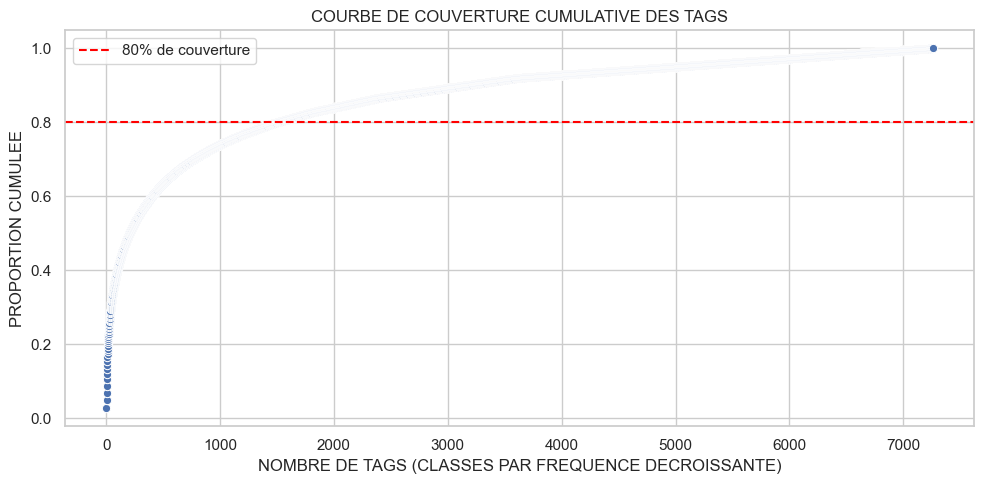

# --- NOMBRE DE TAGS NECESSAIRES POUR COUVRIR 80 % DES OCCURRENCES : 1501
# --- ENTROPIE DE LA DISTRIBUTION DES TAGS : 10.3984 BITS
# --- ENTROPIE MAXIMALE POSSIBLE : 12.8256 BITS
# --- TAUX DE DIVERSITE RELATIVE : 81.08%


In [12]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# -------------------------------------
# --- COMPTE DU NOMBRE DE TAGS UNIQUES
# -------------------------------------
nb_tags_uniques = tag_freq_df["Tag"].nunique()
print(f"# --- NOMBRE DE TAGS DISTINCTS DANS LE CORPUS : {nb_tags_uniques}")
# -------------------------------------
# --- CALCUL DE LA PROPORTION CUMULEE
# -------------------------------------
tag_freq_df["Proportion"] = tag_freq_df["Count"] / tag_freq_df["Count"].sum()
tag_freq_df["Cumulative"] = tag_freq_df["Proportion"].cumsum()
# --------------------------------------------
# --- VISUALISATION DE COUVERTURE CUMULATIVE
# --------------------------------------------
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=tag_freq_df,
    x=range(1, len(tag_freq_df) + 1),
    y="Cumulative",
    marker="o"
)
plt.axhline(0.8, color="red", linestyle="--", label="80% de couverture")
plt.title("COURBE DE COUVERTURE CUMULATIVE DES TAGS")
plt.xlabel("NOMBRE DE TAGS (CLASSES PAR FREQUENCE DECROISSANTE)")
plt.ylabel("PROPORTION CUMULEE")
plt.legend()
plt.tight_layout()
plt.show()
# ----------------------------------------------------------------
# --- NOMBRE DE TAGS NECESSAIRES POUR COUVRIR 80% DES OCCURRENCES
# ----------------------------------------------------------------
nb_tags_80 = (tag_freq_df["Cumulative"] <= 0.8).sum()
print(f"# --- NOMBRE DE TAGS NECESSAIRES POUR COUVRIR 80 % DES OCCURRENCES : {nb_tags_80}")
# ----------------------------------------------------------
# --- ENTROPIE DE LA DISTRIBUTION DES TAGS (SHANNON BASE 2)
# ----------------------------------------------------------
from scipy.stats import entropy
proportions = tag_freq_df["Proportion"].values
tag_entropy = entropy(proportions, base=2)
print(f"# --- ENTROPIE DE LA DISTRIBUTION DES TAGS : {tag_entropy:.4f} BITS")

max_entropy = np.log2(len(proportions))
print(f"# --- ENTROPIE MAXIMALE POSSIBLE : {max_entropy:.4f} BITS")
print(f"# --- TAUX DE DIVERSITE RELATIVE : {tag_entropy / max_entropy:.2%}")

##### 3.5.4. MARQUAGE DES TAGS DOMINANTS  

['c#',
 'java',
 'javascript',
 'python',
 'c++',
 'ios',
 '.net',
 'android',
 'html',
 'objective-c',
 'jquery',
 'iphone',
 'php',
 'c',
 'sql',
 'linux',
 'css',
 'asp.net',
 'xcode',
 'ruby-on-rails',
 'string',
 'arrays',
 'performance',
 'json',
 'asp.net-mvc',
 'c++11',
 'windows',
 'database',
 'sql-server',
 'mysql',
 'node.js',
 'wpf',
 'multithreading',
 'spring',
 'ruby',
 'algorithm',
 'django',
 'unit-testing',
 'bash',
 'swift',
 'cocoa-touch',
 'visual-studio',
 'macos',
 'git',
 'shell',
 'image',
 'ajax',
 'postgresql',
 'debugging',
 'angularjs',
 'eclipse',
 'gcc',
 'google-chrome',
 'hibernate',
 'numpy',
 'rest',
 'pandas',
 'list',
 'unix',
 'xaml',
 'entity-framework',
 'class',
 'security',
 'linq',
 'exception',
 'ipad',
 'http',
 'xml',
 'jpa',
 'ubuntu',
 'twitter-bootstrap',
 'regex',
 'function',
 'r',
 'testing',
 'file',
 'apache',
 'winforms',
 'python-3.x',
 'dictionary',
 'maven',
 'unicode',
 't-sql',
 'logging',
 'oop',
 'date',
 'python-2.7',
 'fo

,Tag,Count,log_count,Proportion,Cumulative,is_dominant_tag
0,c#,1202,7.092574,0.026444,0.026444,True
1,java,1063,6.969791,0.023386,0.049830,True
2,javascript,871,6.770789,0.019162,0.068991,True
3,python,850,6.746412,0.018700,0.087691,True
4,c++,760,6.634633,0.016720,0.104411,True
...,...,...,...,...,...,...
787,char,9,2.302585,0.000198,0.704389,True
788,dispose,9,2.302585,0.000198,0.704587,True
789,overflow,9,2.302585,0.000198,0.704785,True
790,in-app-purchase,9,2.302585,0.000198,0.704983,True


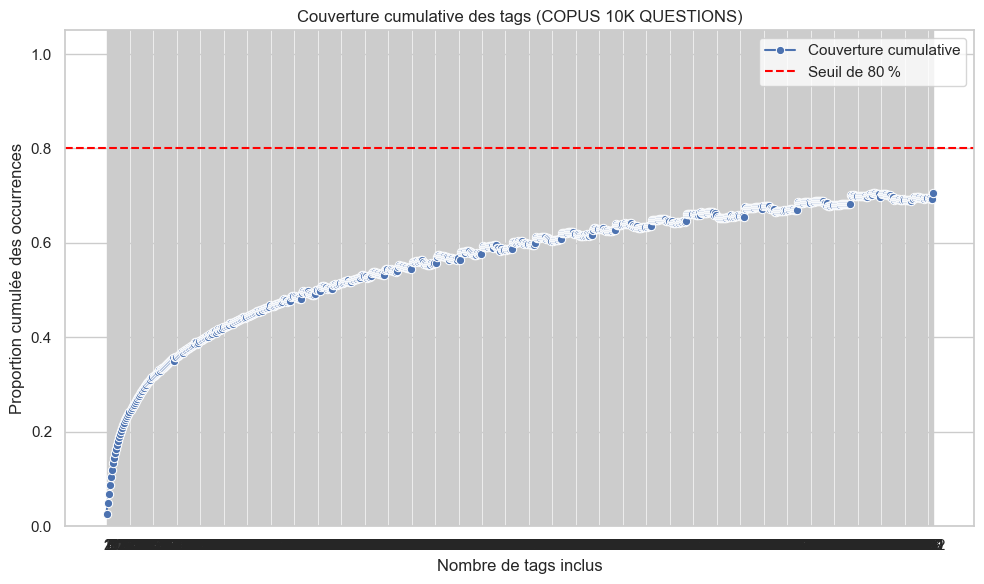

In [13]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ----------------------------------------------
# --- MARQUAGE DES TAGS DOMINANTS SUR LE CORPUS
# ----------------------------------------------
tag_freq_df_marked, dominant_tags = eda.mark_dominant_tags_by_frequency_and_coverage(
    tag_freq_df=tag_freq_df,
    nb_questions=full_explo_wo.shape[0],
    min_coverage=0.8,
    min_count_floor=3
)
# ---------------------------------
# --- AFFICHAGE DES TAGS DOMINANTS
# ---------------------------------
display(dominant_tags)
display(tag_freq_df_marked)
# ----------------------------------------------
# --- VISUALISATION DE LA COUVERTURE CUMULATIVE
# ----------------------------------------------
eda.plot_tag_coverage(
    tag_freq_df_marked,
    coverage_target=0.8,
    title_suffix="COPUS 10K QUESTIONS"
)

#### **3.6. CO-OCCURRENCE DES TAGS**

In [14]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# # --- CONSTRUCTION DES MATRICES
# cooc_matrix, tag_matrix = eda.build_tag_cooccurrence_matrix(
#     df_questions=full_explo_wo,
#     dominant_tags=dominant_tags,
#     tag_col="Tags"
# )
# # --- HEATMAP DES CO OCCURRENCES
# cooc_matrix.style.background_gradient(cmap="Blues")

# eda.plot_tag_cooccurrence_heatmap(cooc_matrix)
# # --- GRAPHE DE CO OCCURRENCE VISUEL
# eda.plot_tag_cooccurrence_graph(
#     cooc_matrix,
#     min_edge_weight=2,           # pour éviter les arêtes anecdotiques
#     layout="spring"              # layout fluide et lisible
# )



<module 'tags_suggester.eda.eda_analysis' from 'd:\\machine_learning_training\\openclassrooms_projects\\05_categorisez_automatiquement_question\\src\\tags_suggester\\eda\\eda_analysis.py'>

## **4. FEATURE ENGINEERING**  

#### **4.1. VECTORISATION TF-IDF**

Shape de la matrice TF-IDF (title + body) : (9091, 6616)
Top 20 mots (title + body) par poids TF-IDF :
image: 124.21
datum: 123.75
user: 122.63
application: 117.25
app: 113.48
time: 111.10
android: 105.02
python: 104.03
server: 101.42
java: 101.20
text: 100.85
gt: 95.84
possible: 95.59
difference: 83.51
number: 83.05
em: 80.06
key: 77.14
javascript: 76.64
database: 75.51
web: 73.13


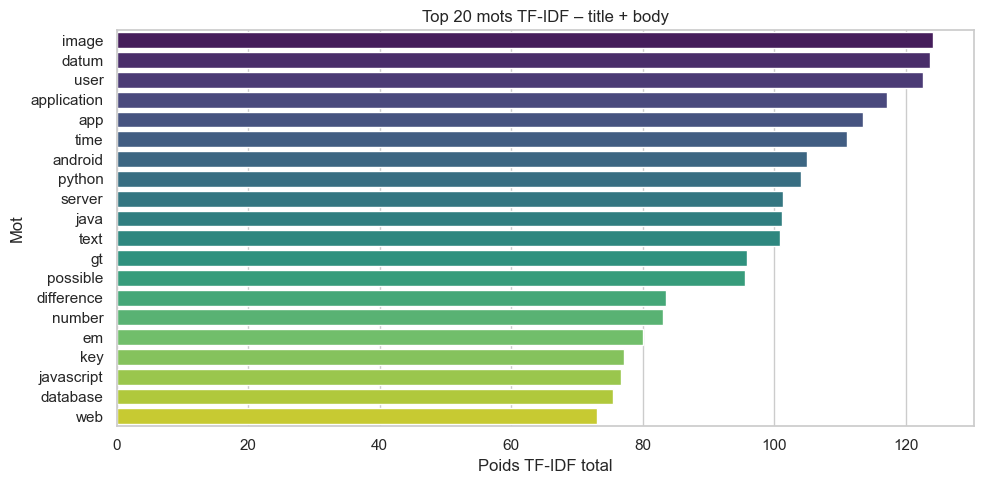

# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\tfidf


In [15]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

X_titlebody_tfidf_full, titlebody_vocab_full, top_titlebody_words_full, tfidf_vectorizer = eda.vectorize_tfidf(
    full_explo_wo["clean_title_body"],
    label="title + body",
    max_features=10000,
    min_df=5,
    top_n=20,
    show_wordcloud=False  # Désactivé si tu veux préserver la RAM
)
import joblib
# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "tfidf"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# --- SAUVEGARDE DU VECTORIZER
joblib.dump(tfidf_vectorizer, api_model_path / "tfidf_vectorizer_titlebody.joblib")
# ---------------------------------------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR LE NOTEBOOK DE MODELISATION SUPERVISEE
# ---------------------------------------------------------------------------------------------
joblib.dump(tfidf_vectorizer, "models/tfidf/tfidf_vectorizer_titlebody.joblib")

# --- SAUVEGARDE DE LA MATRICE TF-IDF POUR ETRE ACCESSIBLE PAR LE NOTEBOOK DE MODELISATION SUPERVISEE
from scipy.sparse import save_npz
import pickle
save_npz("models/tfidf/X_tfidf_full.npz", X_titlebody_tfidf_full)

# --- Sauvegarde du vocabulaire
with open("models/tfidf/vocab_tfidf_full.pkl", "wb") as f:
    pickle.dump(titlebody_vocab_full, f)

with open("models/tfidf/top_titlebody_words_full.pkl", "wb") as f:
    pickle.dump(top_titlebody_words_full, f)

with open("models/tfidf/corpus_full.pkl", "wb") as f:
    pickle.dump(full_explo_wo["clean_title_body"].tolist(), f)

#### **4.2. REDUCTION DE DIMENSION (SVD, PCA)**

Explained variance (title + body) : 0.71%


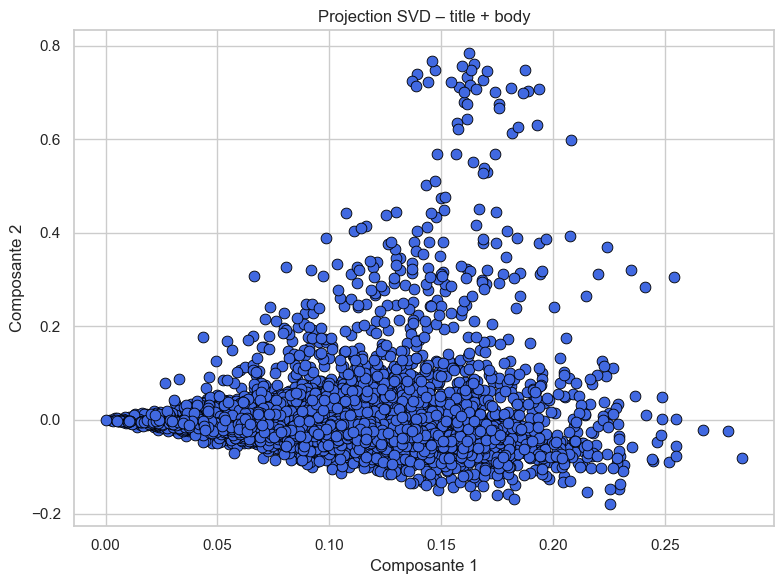

Variance expliquée cumulée (title + body) :
 - 10 composantes : 3.76%
 - 20 composantes : 6.66%
 - 50 composantes : 12.78%


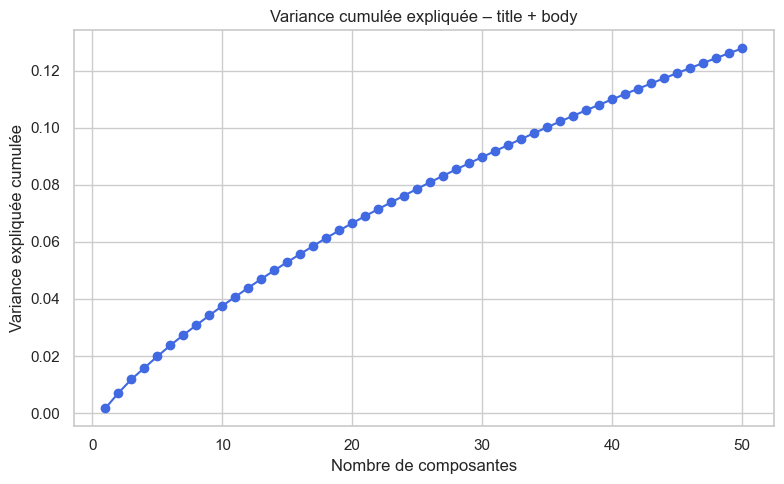

# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\svd


['D:\\machine_learning_training\\openclassrooms_projects\\05_categorisez_automatiquement_question\\src\\tags_suggester\\api\\models\\svd\\svd_model_titlebody.joblib']

In [16]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

from scipy.sparse import load_npz

X_titlebody_tfidf_full = load_npz("models/tfidf/X_tfidf_full.npz")
# -------------------------------------------
# --- REDUCTION SVD POUR UNIQUEMENT VISUALISATION 2D
# -------------------------------------------
X_titlebody_svd_full, svd_titlebody_full = eda.apply_svd_and_plot(
    X_titlebody_tfidf_full,
    label="title + body",
    n_components=2
)
# ----------------------------------------------------------------------------------------
# --- REDUCTION SVD POUR EXTRACTION FEATURES + MODELE SVD PUIS SAUVEGARDES EN .npy ET pkl
# ----------------------------------------------------------------------------------------
X_titlebody_svd10k, svd_titlebody10k = eda.apply_svd_variance(
    X_titlebody_tfidf_full,
    label="title + body",
    n_components=50
)
# -------------------------------------------------------------------------------------------
# --- SAUVEGARDE DU RESULTAT D'ABORD TRANSFORME PAR TFID PUIS REDUIT PAR SVD A 50 DIMENSIONS
# -------------------------------------------------------------------------------------------
import numpy as np
np.save("models/svd/X_titlebody_svd10k.npy", X_titlebody_svd10k)
# --------------------------------------------------------------------------------------
# --- SAUVEGARDE DU MODELE SVD POUR ETRE ACCESSIBLE AU NOTEBOOK MODELISATION SUPERVISEE
# --------------------------------------------------------------------------------------
# --- attention à l'usage api, à partir du texte brute il faut chainer :
#  tfid_vectorizer puis appliquer modele svd_titlebody10k
# import pickle
# with open("models/svd/svd_model_10k.pkl", "wb") as f:
#     pickle.dump(svd_titlebody10k, f)
from pathlib import Path
import joblib

# Construction du chemin avec Path
save_path = Path("models") / "svd" / "svd_model_titlebody.joblib"
save_path.parent.mkdir(parents=True, exist_ok=True)
# Sauvegarde du modèle
joblib.dump(svd_titlebody10k, save_path)


# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
import joblib
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "svd"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# --- SAUVEGARDE DU MODELE SVD POUR L’API
joblib.dump(svd_titlebody10k, api_model_path / "svd_model_titlebody.joblib")



#### **4.3. EMBEDDINGS**

##### 4.3.1. METHODE SBERT

In [17]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

from sentence_transformers import SentenceTransformer
# ---------------------------------------------
# --- CHARGEMENT DU MODELE SBERT PRE ENTRAINE
# ---------------------------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")
# --------------------------------------------------------------------------------------------
# SAUVEGARDE DU MODELE COMPLET EN LOCAL POUR ETRE UTILISE EN NOTEBOOK MODELISATION SUPERVISEE
# --------------------------------------------------------------------------------------------
model.save("models/sbert/sbert_model")
# -------------------------------------------------------------------
# SAUVEGARDE DU MODELE COMPLET EN LOCAL POUR ETRE UTILISE PAR L'API
# -------------------------------------------------------------------
import joblib
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "sbert" / "sbert_model"
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
api_model_path.mkdir(parents=True, exist_ok=True)
model.save(str(api_model_path))


# -------------------------------------------------------------
# --- TRANSFORMATION SBERT DU CORPUS VIA LE MODELE PRE ENTRAINE
# -------------------------------------------------------------
corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()
embeddings_sbert_full = eda.encode_sbert_corpus(corpus_titlebody_full, model=model, batch_size=32)
print(f"--- SBERT Embeddings shape : {embeddings_sbert_full.shape}")
# ------------------------------------------------
# --- SAUVEGARDE DES VECTEURS DE TEXTE TRANSFORME
# ------------------------------------------------
np.save("models/sbert/embeddings_sbert_full.npy", embeddings_sbert_full)

# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\sbert\sbert_model
--- SBERT Embeddings shape : (9091, 384)


##### 4.3.2. METHODE WORD2VEC

In [18]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)
from gensim.models import Word2Vec

# --------------------------------------------------------------------------------------------
# --- CREATION ET SAUVEGARDE DU MODELE A PARTIR DU CORPUS (TOKENISE PUIS VECTORISE PAR TOKEN)
# --------------------------------------------------------------------------------------------
corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()
model_w2v_full = eda.train_word2vec(
    corpus=corpus_titlebody_full,
    save_path="models/w2v/w2v_titlebody_full.bin",  # dossier à créer si nécessaire
    vector_size=100,
    window=5,
    min_count=3,
    epochs=10,
    verbose=True
)
# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
import joblib
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "w2v"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# 💾 Sauvegardes
model_w2v_full.save(str(api_model_path / "w2v_titlebody_full.bin"))




# -------------------------------------------------------------------------------
# --- VECTORISATION DU CORPUS AVEC LE MODELE model_w2v_full QU'ON VIENT DE CREER
# -------------------------------------------------------------------------------
X_w2v_full = eda.vectorize_texts(corpus_titlebody_full, model_w2v_full)
# --- SAUVEGARDE DU CORPUS TRANSFORME PAR LE MODELE WORD2VEC PRENTRAINE PAR LES TOKEN DE NOTRE CORPUS
np.save("models/w2v/X_w2v_full.npy", X_w2v_full)
# w2v_model_full = Word2Vec.load("models/word2vec/word2vec_titlebody_full.bin")
# X_w2v_full = eda.vectorize_texts(corpus_titlebody_full, w2v_model_full)

🔄 Préparation du corpus...

INFO - 2025-08-12 15:00:56,926 - collecting all words and their counts
INFO - 2025-08-12 15:00:56,926 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2025-08-12 15:00:57,024 - collected 23710 word types from a corpus of 291444 raw words and 9091 sentences
INFO - 2025-08-12 15:00:57,024 - Creating a fresh vocabulary



🧠 Corpus prêt avec 9091 documents.


INFO - 2025-08-12 15:00:57,074 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 8714 unique words (36.75% of original 23710, drops 14996)', 'datetime': '2025-08-12T15:00:57.074581', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 2025-08-12 15:00:57,074 - Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 272443 word corpus (93.48% of original 291444, drops 19001)', 'datetime': '2025-08-12T15:00:57.074581', 'gensim': '4.3.3', 'python': '3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 2025-08-12 15:00:57,193 - deleting the raw counts dictionary of 23710 items
INFO - 2025-08-12 15:00:57,195 - sample=0.001 downsamples 38 most-common words
INFO - 2025-08-12 15:00:57,196 - Word2Vec lifecycle event {'msg': 'downsampling

💾 Modèle sauvegardé dans d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\notebooks\models\w2v\w2v_titlebody_full.bin
# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\w2v


##### 4.3.3. METHODE UNIVERSAL SENTENCE ENCODER (USE)

In [19]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------------------------------------------
# --- ACCES AU CHEMIN DU MODELE USE PRE ENTRAINE EN PASSANT PAR KAGGLE
# ---------------------------------------------------------------------
import kagglehub
model_path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")
# ------------------------------------------------------------------------------------------------
# --- SAUVEGARDE DE CE CHEMIN DANS UN FICHIER JSON POUR ACCES ULTERIEUR - TYPIQUEMENT NOTRE API
# ------------------------------------------------------------------------------------------------
import json
with open("models/use/use_path.json", "w") as f:
    json.dump({"path": model_path}, f)

# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
import joblib
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "use"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# --- SAUVEGARDE DU CHEMIN USE DANS UN FICHIER JSON COTE API
with open(api_model_path / "use_path.json", "w") as f:
    json.dump({"path": model_path}, f)

# --------------------------------------------------------------
# --- TRANSFORMATION DU CORPUS GRACE AU MODELE USE PRE ENTRAINE
# --------------------------------------------------------------
corpus_titlebody_full = full_explo_wo["clean_title_body"].fillna("").tolist()
embeddings_use_full = eda.encode_use_corpus(corpus_titlebody_full,model_path, batch_size=100)
print(f"# --- DIMENSIONS DU CORPUS USE : {embeddings_use_full.shape}")
# -----------------------------
# --- SAUVEGARDE DU CORPUS USE
# ------------------------------
np.save("models/use/embeddings_use_full.npy", embeddings_use_full)

# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\use



WARNING - 2025-08-12 15:01:21,007 - From d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\resolver.py:498: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.



WARNING - 2025-08-12 15:01:21,337 - From d:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\venv\Lib\site-packages\tensorflow_hub\module_v2.py:126: The name tf.saved_model.load_v2 is deprecated. Please use tf.compat.v2.saved_model.load instead.

INFO - 2025-08-12 15:03:52,871 - Fingerprint not found. Saved model loading will continue.
INFO - 2025-08-12 15:03:53,355 - path_and_singleprint metric could not be logged. Saved model loading will continue.


✅ USE chargé depuis : C:\Users\hp\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\universal-sentence-encoder\2
# --- DIMENSIONS DU CORPUS USE : (9091, 512)


#### **4.4. VECTORISATION BoW (CountVectorizer)**

In [20]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------
# --- TRANSFORMATION BOW DU CORPUS
# ---------------------------------
corpus_bow_full, X_bow_full, vocab_bow_full, vectorizer_bow_full  = eda.build_bow_matrix(
    df=full_explo_wo,
    col_title="clean_title_body",  # ✅ corpus fusionné
    col_body="clean_title_body",  # ✅ encore le même
    max_df=0.9,
    min_df=5,
    stop_words="english"
)
print("# --- DIMENSIONS DE LA MATRICE BOW :", X_bow_full.shape)
print("# --- TAILLE DU VOCABULAIRE:", len(vocab_bow_full))
# ----------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE A L'API
# ----------------------------------------------------------
import pickle
with open("models/bow/vectorizer_bow_full.pkl", "wb") as f:
    pickle.dump(vectorizer_bow_full, f)

# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
import joblib
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "bow"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# --- SAUVEGARDE DU VECTORIZER
with open(api_model_path / "vectorizer_bow_full.pkl", "wb") as f:
    pickle.dump(vectorizer_bow_full, f)


# -----------------------------------------------------------------------------------------------------------
# --- SAUVEGARDE CORPUS VECTORISE POUR SERVIR D'INPUT A UNE MODELISATION AU NOTEBOOK MODELISATION SUPERVISEE
# -----------------------------------------------------------------------------------------------------------
import scipy.sparse
scipy.sparse.save_npz("models/bow/X_bow_full.npz", X_bow_full)

# -----------------------------------
# --- SAUVEGARDES A TITRE DESCRIPTIF
# -----------------------------------
import pickle
with open("models/bow/corpus_bow_full.pkl", "wb") as f:
    pickle.dump(corpus_bow_full, f)
with open("models/bow/vocab_bow_full.pkl", "wb") as f:
    pickle.dump(vocab_bow_full, f)


# --- DIMENSIONS DE LA MATRICE BOW : (9091, 3964)
# --- TAILLE DU VOCABULAIRE: 3964
# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\bow


#### **4.5. ENCODAGE DES TAGS (MULTI-LABEL BINARIZER)**

Shape du matrix multi-label : (9091, 7259)
# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : D:\machine_learning_training\openclassrooms_projects\05_categorisez_automatiquement_question\src\tags_suggester\api\models\tags


C:\Users\hp\AppData\Local\Temp\ipykernel_9452\3707978131.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tag_freq_df.head(n_top_tags), x="Count", y="Tag", palette="mako")


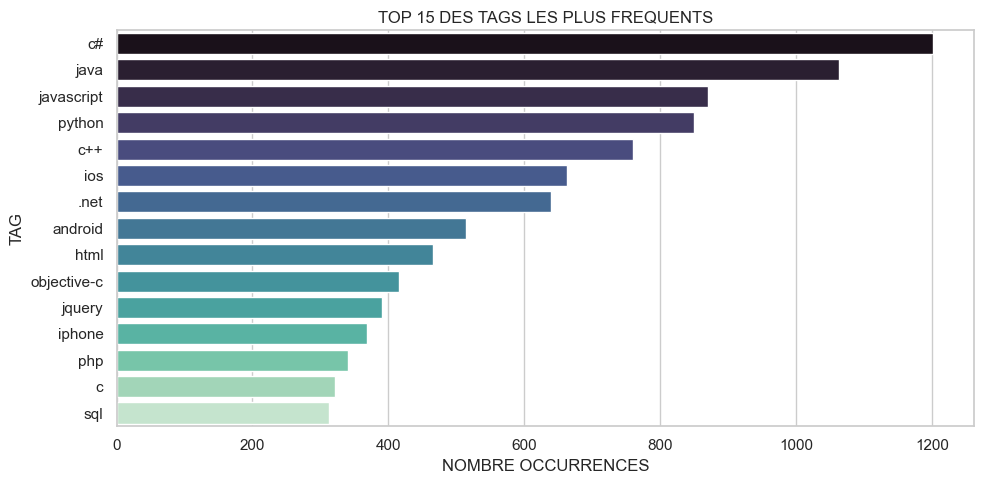

In [21]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

import ast
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# --- VERIFICATION DES TAGS
# --------------------------
if isinstance(full_explo_wo["Tags"].iloc[0], str):
    full_explo_wo["Tags"] = full_explo_wo["Tags"].apply(ast.literal_eval)

# -----------------------------------------------------
# --- ENCODAGE MULTILABEL GRACE AU MultiLabelBinarizer
# ------------------------------------------------------
mlb_full = MultiLabelBinarizer()
tags_encoded_full = mlb_full.fit_transform(full_explo_wo["Tags"])

# ---------------------------------------------------
# --- CONVERSION EN PANDAS DATAFRAME DES TAGS ENCODES
# ---------------------------------------------------
tags_df_full = pd.DataFrame(tags_encoded_full, columns=mlb_full.classes_)
print(f"Shape du matrix multi-label : {tags_encoded_full.shape}")
tags_df_full.to_csv("../data/processed/tags_df_full.csv", index=False)
# -------------------------------------------------------------------
# --- FUSION DU DATAFRAME tags_df_full AVEC DATAGRAME full_explo_wo
# --------------------------------------------------------------------
full_explo_wo = pd.concat([full_explo_wo, tags_df_full], axis=1)

# ---------------------------------------------
# --- SAUVEGARDE DU BINARIZER + VECTEUR ENCODE
# ---------------------------------------------
os.makedirs("models/tags", exist_ok=True)
# --- SAUVEGARDE TAGS ENCODES
np.save("models/tags/y_tags_full.npy", tags_encoded_full)
# --- SAUVEGARDE BINARIZER
joblib.dump(mlb_full, "models/tags/multilabel_binarizer_full.pkl")




# -----------------------------------------------------------------
# --- SAUVEGARDE DU VECTORIZER POUR ETRE ACCESSIBLE PAR L'API
# -----------------------------------------------------------------
from pathlib import Path
# --- BASE PROJET : REMONTER DEPUIS LE NOTEBOOK
notebook_path = Path().resolve()
base_path = notebook_path.parents[0]
# --- CONSTRUCTION CHEMIN EMPLACEMENT API POUR ACCUEILLIR LE VECTORIZER
api_model_path = base_path / "src" / "tags_suggester" / "api" / "models" / "tags"
api_model_path.mkdir(parents=True, exist_ok=True)
print(f"# --- SAUVEGARDE DU VECTORIZER A CET EMPLACEMENT : {api_model_path}")
# 💾 Sauvegarde du binarizer côté API
joblib.dump(mlb_full, api_model_path / "multilabel_binarizer_full.pkl")



# ---------------------------------------------
# --- VISUALISATION  TAGS LES PLUS FREQUENTS
# ---------------------------------------------
tag_counts = tags_df_full.sum().sort_values(ascending=False)
tag_freq_df = tag_counts.reset_index()
tag_freq_df.columns = ["Tag", "Count"]
n_top_tags = 15
tag_title = f"TOP {n_top_tags} DES TAGS LES PLUS FREQUENTS"
plt.figure(figsize=(10, 5))
sns.barplot(data=tag_freq_df.head(n_top_tags), x="Count", y="Tag", palette="mako")
plt.title(tag_title)
plt.xlabel("NOMBRE OCCURRENCES")
plt.ylabel("TAG")
plt.tight_layout()
plt.show()


## **5. EXPORT**

Les artefacts `corpus`, `X_bow` et `vocab` ayant été créés dans la section précédente dédiée à la vectorisation Bag-of-Words, ils sont ici uniquement exportés pour être utilisés dans le notebook `3_modele_non_supervise_lda.ipynb` (modélisation LDA).

Aucun recalcul n’est effectué ici afin de garantir la modularité du pipeline.


In [22]:
# -------------------------------------------
# --- RECHARGEMENT DES MODULES D' EXPLORATION
# -------------------------------------------
import importlib
import tags_suggester.eda.eda_analysis as eda
importlib.reload(eda)

# ---------------------------------
# --- CREATION DU DOSSIER D'EXPORT
# ---------------------------------
os.makedirs("../data/processed", exist_ok=True)
# ------------------------------------------------------------
# --- EXPORT DES DATAFRAMES NETTOYES SANS OUTLIERS ET EXPLORES
# -------------------------------------------------------------
print(f"Dimensions du dataframe full_df : {full_explo_wo.shape}")
print(f" Colonnes du dataframe full_df : {full_explo_wo.columns.tolist()}")
full_explo_wo.to_parquet("data/processed/full_explo_wo.parquet", index=False)

Dimensions du dataframe full_df : (9091, 7274)
 Colonnes du dataframe full_df : ['PostId', 'Title', 'Body', 'Score', 'ViewCount', 'AnswerCount', 'CreationDate', 'TagCount', 'Tags', 'clean_title_body', 'title_body_raw', 'length_words_raw', 'length_words_clean', 'reduction_ratio_global', 'is_outlier', '.doc', '.hgtags', '.htaccess', '.lib', '.net', '.net-1.1', '.net-2.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-assembly', '.net-core', '.net-framework-version', '.net-internals', '.net-remoting', '.refresh', '128-bit', '2d', '2phase-commit', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-reconstruction', '3g', '64-bit', '7zip', 'a-star', 'a2dp', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abcl', 'abi', 'absolute', 'absolute-path', 'absolute-value', 'abstract', 'abstract-class', 'abstract-factory', 'abstract-syntax-tree', 'abstraction', 'accelerate-framework', 'acceptance-testing', 'access-control', 'access-denied', 'access-modifiers', 'access-rights', 'access-token', 'accessi

## ANNEXE 

### A.1. Nomenclature des DataFrames utilisés

| Nom du DataFrame       | Description |
|------------------------|-------------|
| brut_df              | Données brutes chargées depuis le fichier CSV |
| full_clean           | Données complètes nettoyées (lors de la mise à l’échelle) |
| full_explo           | Copie de travail pour l’exploration complète |
| full_explo_wo        | Version sans outliers du corpus complet |


### A.2. RAPPELS DES NOTIONS IMPLIQUEES DANS LE FEATURE ENGINEERING EN NLP

Cette annexe vise à expliciter les concepts mathématiques et vectoriels sous-jacents aux principales étapes de transformation des textes dans le cadre du NLP. Elle s’adresse à un lecteur ayant une formation scientifique avancée.



#### A.2.1. Vecteurs creux vs. vecteurs denses

- Un **vecteur creux** (sparse vector) est un vecteur dont la majorité des composantes sont nulles.
  - Exemple : `[0, 0, 0.5, 0, 0, 0.3, 0, 0, 0, 0.2]`
  - Typique des représentations TF-IDF : chaque document n’utilise qu’un petit sous-ensemble du vocabulaire.

- Un **vecteur dense** est un vecteur dont la plupart des composantes sont non nulles.
  - Exemple : `[0.12, -0.03, 0.45, 0.08, -0.22, 0.19]`
  - Typique des embeddings ou des vecteurs après réduction de dimension.



#### A.2.2. Variables latentes et espace latent

- Une **variable latente** est une variable non observée directement, mais déduite à partir des données.
- En NLP, les **axes latents** correspondent à des thématiques ou structures cachées dans les textes.
- L’**espace latent** est un espace vectoriel réduit, où chaque dimension représente une composante thématique implicite.



#### A.2.3. Base canonique vs. base sémantique

- La **base canonique** est formée par les mots du vocabulaire : chaque mot est une dimension orthogonale.
- Elle est arbitraire, très grande, et souvent redondante.
- Une **base sémantique** est une base apprise ou extraite (via SVD ou embeddings) où chaque dimension reflète un thème ou une proximité de sens.
- Elle est plus compacte, plus informative, mais non orthogonale.



#### A.2.4. Décomposition SVD (Singular Value Decomposition)  

Soit une matrice TF-IDF X de taille (m × n), où :

- m est le nombre de documents
- n est la taille du vocabulaire (nombre de mots uniques)
- Chaque ligne de X est un vecteur TF-IDF représentant un document

La décomposition en valeurs singulières (SVD) permet d’écrire :

X = U × Σ × Vᵗ

avec :

- U ∈ ℝ^(m × r) : matrice des vecteurs propres des documents (orthogonaux)
- Σ ∈ ℝ^(r × r) : matrice diagonale contenant les valeurs singulières décroissantes
- V ∈ ℝ^(n × r) : matrice des vecteurs propres des mots (orthogonaux)

où r est le rang de X (r ≤ min(m, n))


**Réduction de dimension**

En pratique, on ne conserve que les k premières composantes (avec k ≪ r), ce qui donne une approximation de rang k :

X ≈ U_k × Σ_k × V_kᵗ

avec :

- U_k ∈ ℝ^(m × k) : projection des documents dans un espace latent de dimension k
- Σ_k ∈ ℝ^(k × k) : valeurs singulières principales
- V_k ∈ ℝ^(n × k) : projection des mots dans le même espace latent


**Interprétation**

- Chaque document est représenté par un vecteur dense de dimension k, capturant ses composantes thématiques latentes
- Chaque mot est également projeté dans cet espace, révélant ses affinités sémantiques
- Les valeurs singulières indiquent l’importance relative de chaque axe latent

**Utilité en NLP**

- Réduction de dimension : compresser les vecteurs TF-IDF très grands et creux
- Suppression du bruit lexical : éliminer les dimensions peu informatives
- Découverte de thématiques : chaque axe latent peut être interprété comme un thème sémantique

Cette technique est à la base de la méthode LSA (Latent Semantic Analysis).

#### A.2.5. Embeddings (Word2Vec, FastText, BERT…)

- Les **embeddings** sont des vecteurs denses appris par des modèles de langage.
- Ils sont construits pour que les mots ayant des contextes similaires aient des vecteurs proches.
- Contrairement à TF-IDF, ils capturent :
  - La **sémantique** (proximité de sens)
  - Le **contexte** (dans les modèles comme BERT)
  - Les **relations syntaxiques** et **logiques**

Exemple d’analogie vectorielle :  
`king - man + woman ≈ queen`

Mathématiquement, les embeddings sont issus d’une **factorisation implicite** de la matrice de co-occurrence des mots, ou d’un apprentissage supervisé/non supervisé sur des tâches de prédiction de contexte.



#### A.2.6. Encodage des tags – MultiLabelBinarizer

- Les tags sont des cibles multi-label (un document peut avoir plusieurs étiquettes).
- Le **MultiLabelBinarizer** transforme chaque liste de tags en un vecteur binaire.

Exemple :

| Tags | Encodage |
|------|----------|
| ['python', 'django'] | [1, 0, 1, 0, …] |

Chaque dimension correspond à un tag unique.  
Ce format est requis pour entraîner un modèle de classification multi-label.



#### A.2.7. Résumé global du pipeline vectoriel

| Étape | Entrée | Sortie | Objectif |
|-------|--------|--------|----------|
| TF-IDF | Texte brut | Vecteurs creux | Pondérer les mots |
| SVD / PCA | TF-IDF | Vecteurs denses réduits | Capturer les axes thématiques |
| Embeddings | Texte brut | Vecteurs denses sémantiques | Capturer le sens |
| MultiLabelBinarizer | Tags | Vecteurs binaires (cibles) | Préparer les cibles |

---


### A.3. FONCTIONNEMENT DE FASTAPI - à compléter plus tard

### A.4. ACCES AU MODELE PRE ENTRAINE USE VIA KAGGLE

In [23]:
# import kagglehub
# path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")
# print("✅ Modèle téléchargé dans :", path)
